###  Objective
we are going to use the SIR with standard incidence to investigate the parameter dynamics of the SARS Covid-19 case in senegal

### Practical:  SIR approximated

In the context of sars cov 2 in the world, we need to adapt SIR model to our data such that we can make some approximation on behavior of disease and define transmission rate and others. If we consider **(N)**  the number of population in some fixed surface ($Km^{2}$) at time t. We know that there will exist some confirmed cases population and non confirmed cases population.

**population size = totalpositivecases + totalnegativecases** and **totalpositivecases = currentpositivecases + (recovered + death)**

hence,

**population size = totalnegativecases + currentpositivecases + recovered + death**  (1)

From (1) we can make some identification:

> population size can be a total Population (N).

> totalnegativecases can be a Susceptible (S)

> currentpositivecases can be an Infective (I) 

> recovered + death can be a Recovered individuals (R) + Fatalities (F)

We can write again:

$S = N  - S_c \rightarrow \dfrac{S}{N} = 1 - \dfrac{S_c}{N}$ if $  \dfrac{S_c}{N} << 1 $ we have $S \approx N$ and SIR Model with standard  incidence become:

$\dfrac{dI}{dt} = (\beta - \gamma - \delta)I$, $\qquad$ $\dfrac{dR}{dt} = \gamma I$ 

# Behaviour of Covid 19 disease 

The behaviour of disease depends on the state of ratio reproductive number $R_0(t)$ over time. Disease have three behaviours following the state of $R_0(t)=\dfrac{\beta(t) }{\gamma(t)+\delta(t)}$.

> If $\dfrac{dI}{Idt} > 0$ then $R_{0}(t) > 1 $ **the disease outbreaks again**.

> If $\dfrac{dI}{Idt} \approx 0$ then $R_{0}(t) \approx 1 $, also $ \beta(t) \approx \gamma(t)+\delta(t)$ **the disease remains constant over time, it is the buffer state of the disease**.

> If $\dfrac{dI}{Idt} < 0$  then $R_{0}(t) < 1 $ **the disease die out**.

In [16]:
#Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import cachetools.func
import datetime

<p>The following cells are responsible for crawling the data and processing it</p>

In [5]:
#-----      
#-----
def fix_region_name(df, pairs = [["Mainland China", "China"]]):
  # fix region names
    for p in pairs:
        df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])
    return df

#-----
def merge_df_data(df1,df2):
    return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

#-----
def str_add_func(*args):      
    out = []
    for x in args:
        if isinstance(x,str):
            out.append(x)
  
    return '_'.join(out)


class covid_data():
    '''
      Python class to obtain global COVID19 data from 
      John Hopkins GIT repository. This data is updated daily, 
      and the most upto date information available on the web.  
    '''
    def __init__(self,**kwargs):
        nrow = kwargs.get('nrow',None)
        self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)
    @staticmethod
    def create_ts(df):
        ts=df
        columns = ts['region']
        ts=ts.drop(['Province/State', 
                    'Country/Region',
                    'Lat', 
                    'Long',
                    'Population'], 
                   axis=1).set_index('region').T    

        ts.columns = columns 
        ts=ts.fillna(0)
        #
        ts.index.name = 'Date'
        return ts

    def search_agg(self, name,col='Country/Region',ts=True):
    
        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():

        #pd.columns(columns=)
            df_list= []     
            for n in name:
                df = v[v[col]==n].set_index(col).filter(regex='/20')
                df_list.append(df.sum(axis=0))

            df = pd.concat(df_list,axis=1, sort=False)
            df.columns = name
            out[k] = df

        # if ts:                
        #   out[k] = self.create_ts(df)
        # else:
        #   out[k] = df.T

        return out

    def search(self, name,col='Country/Region',ts=True):
        if not isinstance(name,list):
            name = [name]
        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
            if ts:                
                out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
            else:
                out[k] = v[v[col] in name].T
        return out

    @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
    def get_csseg_data(self, nrow=None):
    
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
        path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

        # 
    
        url = f'{path}/time_series_covid19_confirmed_global.csv'
        confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_deaths_global.csv'
        dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_recovered_global.csv'
    
        recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        print(confirmed.head())
        #
        return confirmed, dead, recovered


In [6]:
cd = covid_data()
cd.confirmed.head()
countries = ['Senegal']
mm = cd.search_agg(countries)

  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  7/29/20  7/30/20  7/31/20  8/1/20  \
0        0        0        0        0  ...    36471    36542    36675   36710   
1        0        0        0        0  ...     5105     5197     5276    5396   
2        0        0        0        0  ...    29229    29831    30394   30950   
3        0        0        0        0  ...      918      922      925     925   
4        0        0        0        0  ...     1078     1109     1148    1164   

   8/2/20  8/3/20  8/4/20  8/5/20  8/6/20  8/7/20  
0   36710   3674

In [12]:
for ix, ctype in enumerate(['confirmed', 'dead', 'recovered']):
    df = mm[ctype].stack().reset_index()
    #print(df.head())
    df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        df['date'] = pd.to_datetime(df['date'])
        dfall = df
    else:
        dfall[ctype] = df[ctype]

In [13]:
dfall.drop(['country'],axis=1,inplace=True)
dfall['currentCase'] = dfall['confirmed'] - dfall['recovered'] - dfall['dead']
dfall.columns=['ObservationDate', 'Confirmed', 'Deaths', 'Recovered','currentCase']
dfall=dfall.loc[dfall['Confirmed']>=100]

In [14]:
dfall.isnull().sum()
dfall

,ObservationDate,Confirmed,Deaths,Recovered,currentCase
64,2020-03-26,105,0,9,96
65,2020-03-27,119,0,11,108
66,2020-03-28,130,0,18,112
67,2020-03-29,142,0,27,115
68,2020-03-30,162,0,27,135
...,...,...,...,...,...
194,2020-08-03,10386,211,6901,3274
195,2020-08-04,10432,214,6920,3298
196,2020-08-05,10538,218,6988,3332
197,2020-08-06,10715,223,7101,3391


In [25]:
#Checks if there are no missing date
assert len(dfall)==(datetime.datetime(2020,8,7)-datetime.datetime(2020,3,26)).days+1 

## Parameter dynamics

In [26]:
def determinate_beta_gamma_delta(data=None):
    '''
        this function compute transmission rate, recovered rate and fatalities rate over time
        params: data
        return: beta, gamma, delta
    '''
    
    beta = []
    gamma = []
    delta = []
    
    for t in range(len(data.ObservationDate.values)):
        
        x = data.Confirmed.iloc[t]
        y = data.Deaths.iloc[t]
        z = data.Recovered.iloc[t]
        w = data.currentCase.iloc[t]
        
        if x == 0.0:
            beta.append(0)
            gamma.append(0)
            delta.append(0)
        else:
            beta_t = w/x
            gamma_t = z/x
            delta_t = y/x
            
            beta.append(beta_t)
            gamma.append(gamma_t)
            delta.append(delta_t)
            
    return np.array(beta), np.array(gamma), np.array(delta)        

In [27]:
transmission, recovery, fatality = determinate_beta_gamma_delta(data=dfall)

In [28]:
parameter_dynamic = pd.DataFrame()
parameter_dynamic['beta'] = transmission
parameter_dynamic['gamma'] = recovery
parameter_dynamic['delta'] = fatality
parameter_dynamic.index = dfall.ObservationDate

In [29]:
def find_R0(data=None):
    '''
        This function compute R0 over time
        params: data
        return: R0
    '''
    return data.beta.values/(data.gamma.values + data.delta.values)

In [30]:
#Compute R0
parameter_dynamic['R0'] = find_R0(data=parameter_dynamic)
print(parameter_dynamic['R0'].min())
parameter_dynamic.columns=['\u03B2', '\u03B3', '\u03B4','R0']
parameter_dynamic.columns

0.4313955436421511


Index(['β', 'γ', 'δ', 'R0'], dtype='object')

In [31]:
parameter_dynamic

,β,γ,δ,R0
ObservationDate,,,,
2020-03-26,0.914286,0.085714,0.000000,10.666667
2020-03-27,0.907563,0.092437,0.000000,9.818182
2020-03-28,0.861538,0.138462,0.000000,6.222222
2020-03-29,0.809859,0.190141,0.000000,4.259259
2020-03-30,0.833333,0.166667,0.000000,5.000000
...,...,...,...,...
2020-08-03,0.315232,0.664452,0.020316,0.460349
2020-08-04,0.316143,0.663344,0.020514,0.462293
2020-08-05,0.316189,0.663124,0.020687,0.462392


(18347.0, 18481.0)


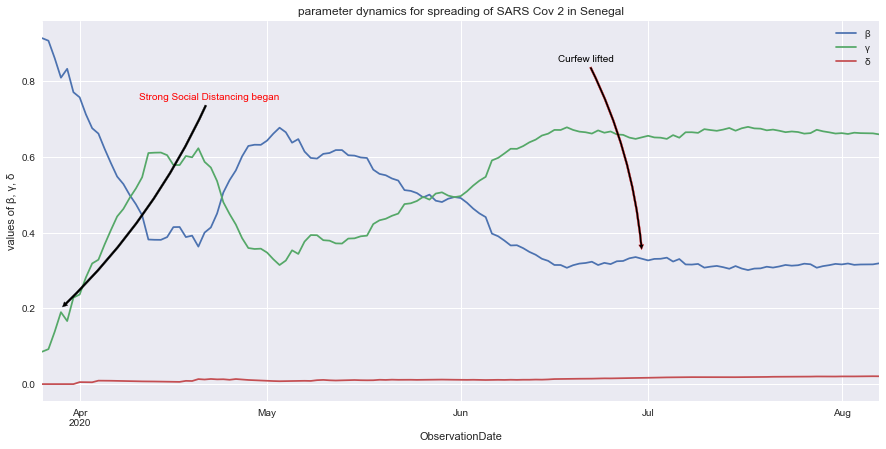

In [39]:
plt.style.use('seaborn')
ax=parameter_dynamic[['\u03B2', '\u03B3', '\u03B4']].plot(figsize=(15,7))
print (ax.get_xlim())
plt.ylabel('values of \u03B2, \u03B3, \u03B4')
plt.annotate(
        'Strong Social Distancing began',
        xy=(18350.0, 0.2),
        xycoords="data",
        xytext=(0.2, 0.8),
        textcoords="axes fraction",
        size=10,
        va="center",
        color='red',
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.1", fc="black"
        ),transform=ax.transAxes)
plt.annotate(
        'Curfew lifted',
        xy=(18443.0, 0.35),
        xycoords="data",
        xytext=(0.65, 0.9),
        textcoords="axes fraction",
        size=10,
        va="center",
        color='black',
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.1", fc="black",color='red'
        ),transform=ax.transAxes)
plt.title('parameter dynamics for spreading of SARS Cov 2 in Senegal')
plt.savefig('paramater dynamics.png',bbox_inches='tight')

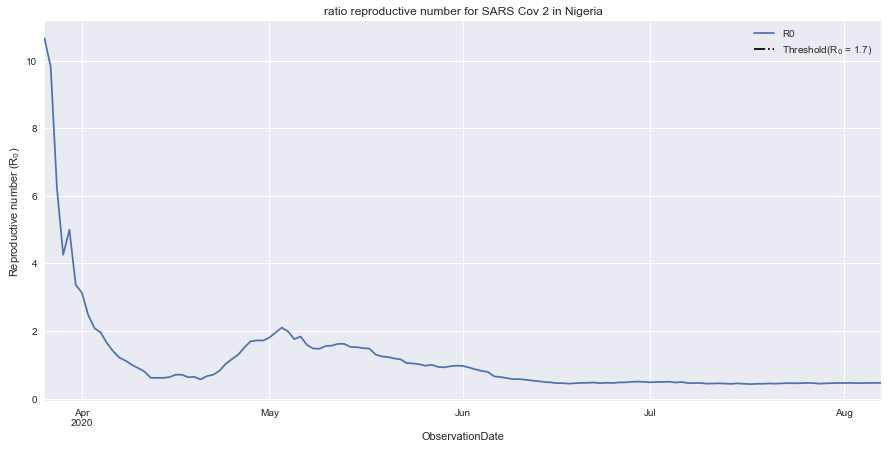

In [40]:
# Plot R0
parameter_dynamic['R0'].plot(figsize=(15,7))
plt.ylabel('Reproductive number' + ' (R' + r'$_0$' +')')
plt.hlines(1.67, 10, 60, linestyles='dashdot', label='Threshold'+'(R' + r'$_0$' +' = 1.7)')
plt.legend(loc='best')
plt.title('ratio reproductive number for SARS Cov 2 in Nigeria')
plt.savefig('reproductive rate.png')